# Simplagion Model

In [1]:
import networkx as nx
import numpy as np
from scipy import random
import copy
import random
from collections import OrderedDict
import pickle
import itertools

from multiprocessing import Pool

from utils_simplagion_on_RSC import *

from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

## Single simulation 

In [2]:
it_num = 1
N = 2000

k1 = 20
k2 = 6
p1, p2 =  get_p1_and_p2(k1,k2,N) 

lambda1s = np.linspace(0.2,2.2,30)     
lambdaD_target = 2.5

I_percentage, t_max, mu = 1, 1000, 0.05
args = [it_num, N, p1, p2, lambda1s, lambdaD_target, I_percentage, t_max, mu]
rhos, real_k, real_kD  = run_one_simulation(args)

It 1 initialized
not connected, but GC has order 1999 ans size 8058
It 1, created SC with k1=19.8 and k2=5.9
It 1, simulation has finished


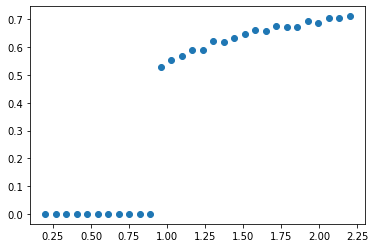

In [3]:
plt.plot(lambda1s, rhos, 'o')

## Bulk Simulation

In [4]:
#Simplicial complex parameters
N = 2000                   
k1 = 20
k2 = 6

p1, p2 = get_p1_and_p2(k1,k2,N)

#Infection parameters
mu = 0.05
lambda1s = np.linspace(0.2,2.2,30)     
lambdaD_target_list = [0,0.8,2.5,2.5]
I_percentage_list = [1,1,1,40] #initial conditions (% of infected)

#Simulation Parameters
t_max = 6000                 
n_simulations = 120
n_processes = 8

out_dir = 'simplagion-results/'

In [5]:
!mkdir ./simplagion-results/

mkdir: ./simplagion-results/: File exists


In [ ]:
iteration_numbers = range(n_simulations)

for lambdaD_target, I_percentage in tqdm(list(zip(lambdaD_target_list, I_percentage_list))):
    print('lambdaD', lambdaD_target, 'seed', I_percentage)

    ################################ Preparing arguments for the parallel processing
    args=[]
    for it_num in range(n_simulations):
        args.append([it_num, N, p1, p2, lambda1s, lambdaD_target, I_percentage, t_max, mu])

    ################################ Running in parallel
    pool = Pool(processes=n_processes)                         
    results = pool.map(run_one_simulation, args)
    
    ################################ Saving
    filename = 'result_RSC_'+'N'+str(N)+'_k'+str(k1)+'_kD'+str(k2)+'_mu'+str(mu)+'_lD'+str(lambdaD_target)+'_seed'+str(I_percentage)+'.p'
    pickle.dump(results, open(out_dir+filename, "wb" ))

  0%|          | 0/4 [00:00<?, ?it/s]

lambdaD 0 seed 1


### Plotting

In [ ]:
N = 2000     
k1 = 20
k2 = 6
cut = True
lambda1s = np.linspace(0.2,2.2,30)     
lambdaD_target_list = [2.5,2.5,0.8,0]
I_percentage_list = [40,1,1,1] #initial conditions (% of infected)
mu = 0.05
out_dir = 'simplagion-results/'

############################# Preparing MF
MF_x=np.linspace(0.2,2.2,200)

MF_y_dict = {}

for i, (lambdaD_target, I_percentage) in enumerate(zip(lambdaD_target_list, I_percentage_list)):
    
    if i != 1:
        filename = 'result_RSC_'+'N'+str(N)+'_k'+str(k1)+'_kD'+str(k2)+'_mu'+str(mu)+'_lD'+str(lambdaD_target)+'_seed'+str(I_percentage)+'.p'
        results = pickle.load(open(out_dir+filename, "rb" ))
        _, avg_k, avg_kD = parse_results(results, cut=cut)

        beta2 = (mu*lambdaD_target)/k2
        real_lambdaD = 1.*(beta2*avg_kD)/mu
        
        #fixing for lD=0:
        if real_lambdaD==0: real_lambdaD = 0.0000001

        MF_y = list(map(lambda xx: get_rho_MF(xx, real_lambdaD), MF_x))
        MF_y_dict[i] = MF_y

In [ ]:
fig = plt.figure(figsize=(4.5,3));
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

markers = ['o','o','s','o']
zorders = [8,7,6,5]
mfcs = ['white', 'white', 'white', 'cornflowerblue']
lables = [r'$\lambda_\Delta=2.5$','',r'$\lambda_\Delta=0.8$', r'$\lambda_\Delta=0$']
markersizes = [7.5,7.5,7,6]

ax = plt.subplot(111)

for i, (lambdaD_target, I_percentage) in enumerate(zip(lambdaD_target_list, I_percentage_list)):
    filename = 'result_RSC_'+'N'+str(N)+'_k'+str(k1)+'_kD'+str(k2)+'_mu'+str(mu)+'_lD'+str(lambdaD_target)+'_seed'+str(I_percentage)+'.p'
    results = pickle.load(open(out_dir+filename, "rb" ))
    avg_rhos, avg_k, avg_kD = parse_results(results, cut=cut)
    
    ax.plot(lambda1s, avg_rhos, markers[i], color='black', zorder=zorders[i],
            mfc=mfcs[i], markersize=markersizes[i], label=lables[i])

    if i != 1:
        ax.plot(MF_x, MF_y_dict[i], '-', markersize=2, color=u'#ff7f0e')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel(r'Rescaled infectivity, $\lambda$', size=16)
ax.set_ylabel(r'Density of infected nodes, $\rho^{*}$', size=16)
ax.set_xlim(0.2,2.2)
ax.set_ylim(-0.01,0.8);
ax.set_yticks([0,0.2,0.4,0.6,0.8]);

lgd = ax.legend(fontsize=13, handlelength=1, handletextpad=0.3, borderaxespad=0.2,
                loc='lower right', labelspacing=0.2, borderpad=0.4)  
ax.add_artist(lgd)

h = plt.plot([],[],'-', color=u'#ff7f0e', markersize=2, label='MF')
lgd = plt.legend(handles=h, loc=(0.02,0.82), frameon=False, fontsize=14, handlelength=1, borderpad=0.1)
ax.add_artist(lgd)

ax.annotate('SIS', (2,0.38), fontsize=13)

plt.tight_layout()
